In [1]:
!pip install lexicalrichness
!pip install seaborn

## Downloading data and python code from https://github.com/ArGintum/GPTID repository

In [2]:
!wget https://github.com/ArGintum/GPTID/raw/main/data/human_gpt3_davinci_003_reddit.zip
!unzip human_gpt3_davinci_003_reddit.zip -d -Y .

!wget https://github.com/ArGintum/GPTID/raw/main/data/human_gpt3_davinci_003_wikip.zip
!unzip human_gpt3_davinci_003_wikip.zip -d -Y .

!wget https://github.com/ArGintum/GPTID/raw/main/IntrinsicDim.py

--2025-06-03 08:54:03--  https://github.com/ArGintum/GPTID/raw/main/data/human_gpt3_davinci_003_reddit.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ArGintum/GPTID/main/data/human_gpt3_davinci_003_reddit.zip [following]
--2025-06-03 08:54:04--  https://raw.githubusercontent.com/ArGintum/GPTID/main/data/human_gpt3_davinci_003_reddit.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4100402 (3.9M) [application/zip]
Saving to: ‘human_gpt3_davinci_003_reddit.zip.6’

human_gpt3_davinci_ 100%[===================>]   3.91M  --.-KB/s    in 0.08s   

2025-06-03 08:54:04 (49.0 MB/s) - ‘human_gpt3_

In [20]:
import numpy as np
import pandas as pd
import random

from IntrinsicDim import PHD

from lexicalrichness import LexicalRichness
from sklearn.utils import shuffle
from transformers import RobertaTokenizer, RobertaModel
import torch

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

np.random.seed(42)
random.seed(42)

#import os
#os.environ["REQUESTS_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt"
#os.environ["SSL_CERT_FILE"] = "/etc/ssl/certs/ca-certificates.crt"
import pickle as pk

In [4]:
DEVICE = "cuda:0"
MAX_LEN = 512
EXAMPLES_PER_DF = 250

In [5]:
reddit_path_gpt3 = "human_gpt3_davinci_003_reddit.json_pp"
wiki_path_gpt3 = "human_gpt3_davinci_003_wikip.zip"

In [6]:
df_gpt3_w = pd.read_json(wiki_path_gpt3, lines=True)
df_gpt3_r = pd.read_json(reddit_path_gpt3, lines=True)
df_gpt3_w = [df_gpt3_w[i][0] for i in range(len(df_gpt3_w.columns))]
df_gpt3_r = [df_gpt3_r[i][0] for i in range(len(df_gpt3_r.columns))]
df_gpt3_w = df_gpt3_w[:EXAMPLES_PER_DF]
df_gpt3_r = df_gpt3_r[:EXAMPLES_PER_DF]
len(df_gpt3_r), len(df_gpt3_w)

(250, 250)

In [7]:
print(df_gpt3_r[0].keys())

dict_keys(['prefix', 'gold_completion', 'gen_completion', 'paraphrase_outputs', 'split'])


In [8]:
text_sets = {"gpt_w_3": list(map(lambda x: x['gen_completion'], df_gpt3_w)),
             "gpt_r_3": list(map(lambda x: x['gen_completion'], df_gpt3_r)),
             "human_w": list(map(lambda x: x['gold_completion'], df_gpt3_w)),
             "human_r": list(map(lambda x: x['gold_completion'], df_gpt3_r))
            }

In [9]:
text_sets["gpt_w_3"][10]

'The Australians continued their advance into September, but by mid-September the advance had ground to a halt due to the lack of supplies and the difficulty of moving through the mountainous terrain. The Australians were forced to dig in and wait for reinforcements and supplies before they could make further progress.\n\nIn October, the Australian advance resumed with a renewed vigour, and by late November, the Australians had reached the outskirts of Buin. On the night of the 7th of December, Australian forces launched a surprise attack on the Japanese defences and captured the town. The Australians then continued their advance into the mountains, and by the end of December, they had secured the entire area.\n\nThe battle for Buin was the last major battle of the Bougainville campaign and marked the end of the fighting in the region. Although the Australians had achieved victory, the cost had been high. The Australians had suffered over 2000 casualties, with over 600 killed in action

## Calculating Lexical Richness

Please see https://pypi.org/project/lexicalrichness/#methods for details

In [10]:
lexrich_functions = { \
                      "MATTR": lambda x: LexicalRichness(x).mattr(window_size=15),
                      "MTLD": lambda x: LexicalRichness(x).mtld(threshold=0.72),
                      "Herdan": lambda x: LexicalRichness(x).Herdan,
                      "Summer": lambda x: LexicalRichness(x).Summer,
                      "Dugast": lambda x: LexicalRichness(x).Dugast,
                      "Maas": lambda x: LexicalRichness(x).Maas,
                      "yulek": lambda x: LexicalRichness(x).yulek,
                      "yulei": lambda x: LexicalRichness(x).yulei,
                      "herdanvm": lambda x: LexicalRichness(x).herdanvm,
                      "simpsond": lambda x: LexicalRichness(x).simpsond,
}

In [11]:
lexrich_ylims = { \
                      "MATTR": [0.6, 1.2],
                      "MTLD": [0, 200],
                      "Herdan": [0.7, 1],
                      "Summer": [0.8, 1],
                      "Dugast": [0, 100],
                      "Maas": False,
                      "yulek": False,
                      "yulei": [0, 100],
                      "herdanvm": False,
                      "simpsond": False,
}

In [12]:
text_sets.keys()

dict_keys(['gpt_w_3', 'gpt_r_3', 'human_w', 'human_r'])

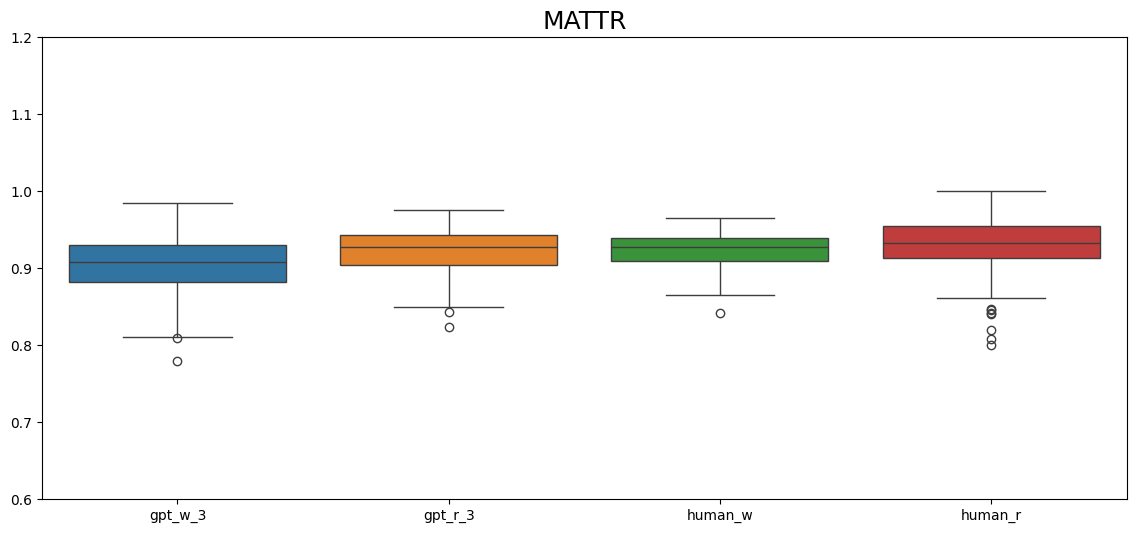

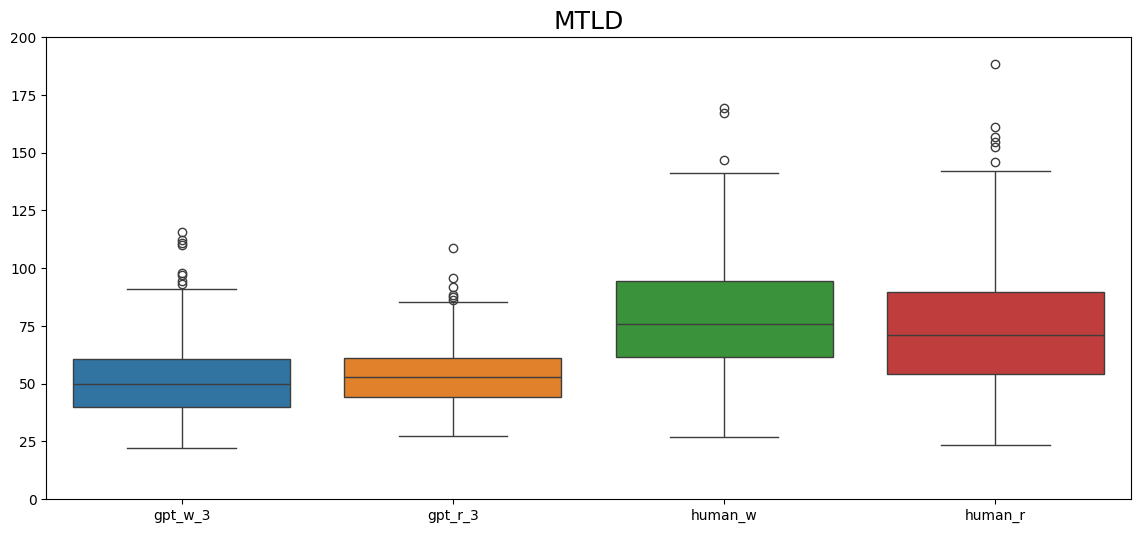

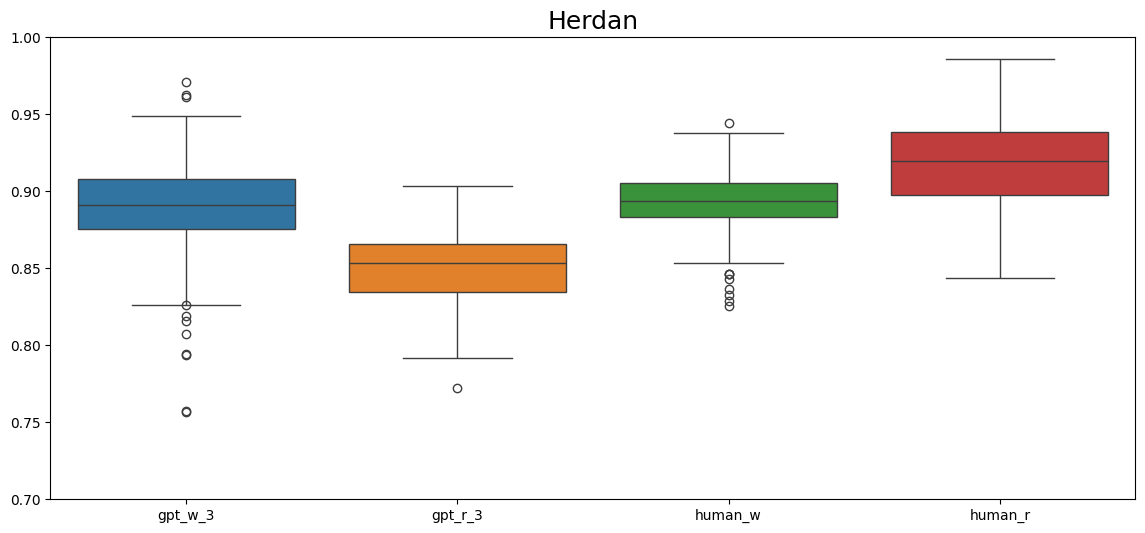

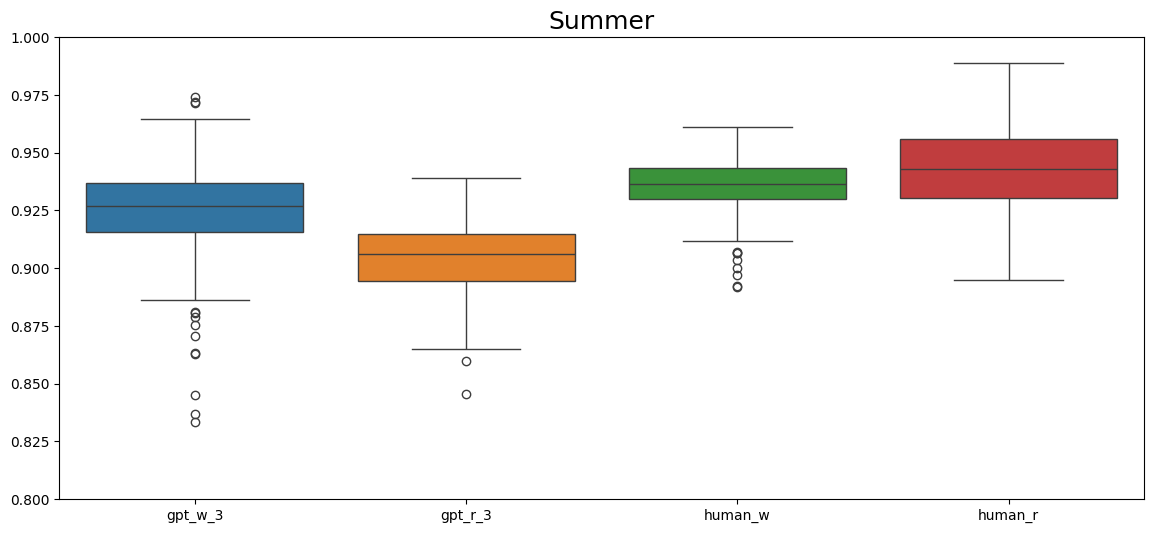

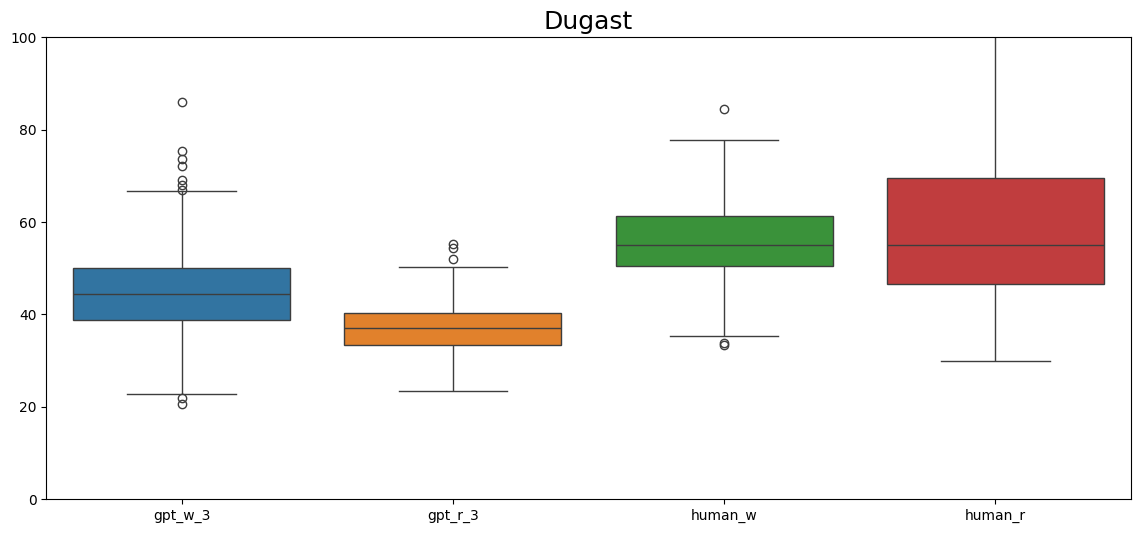

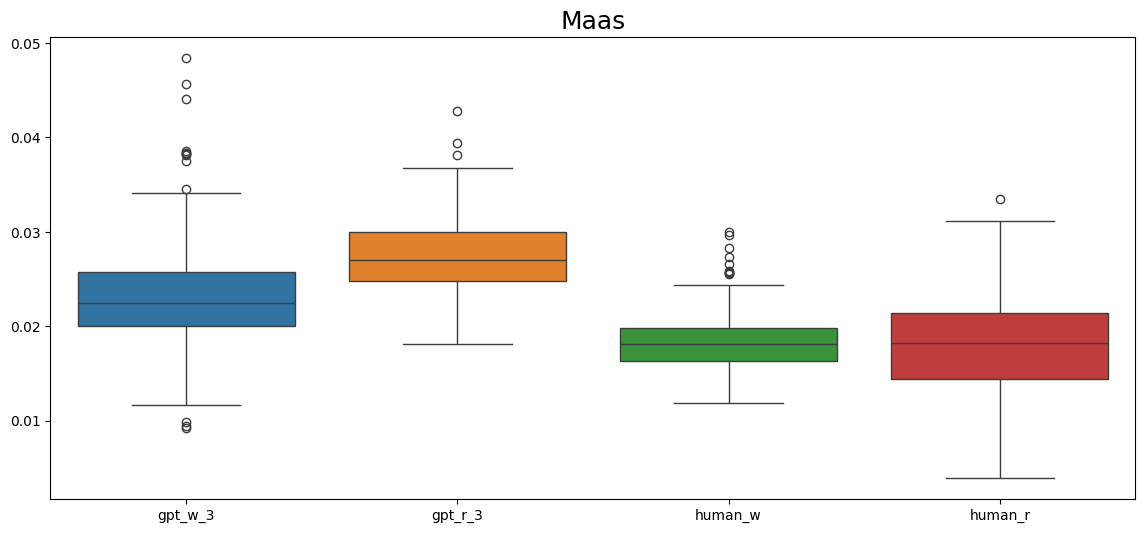

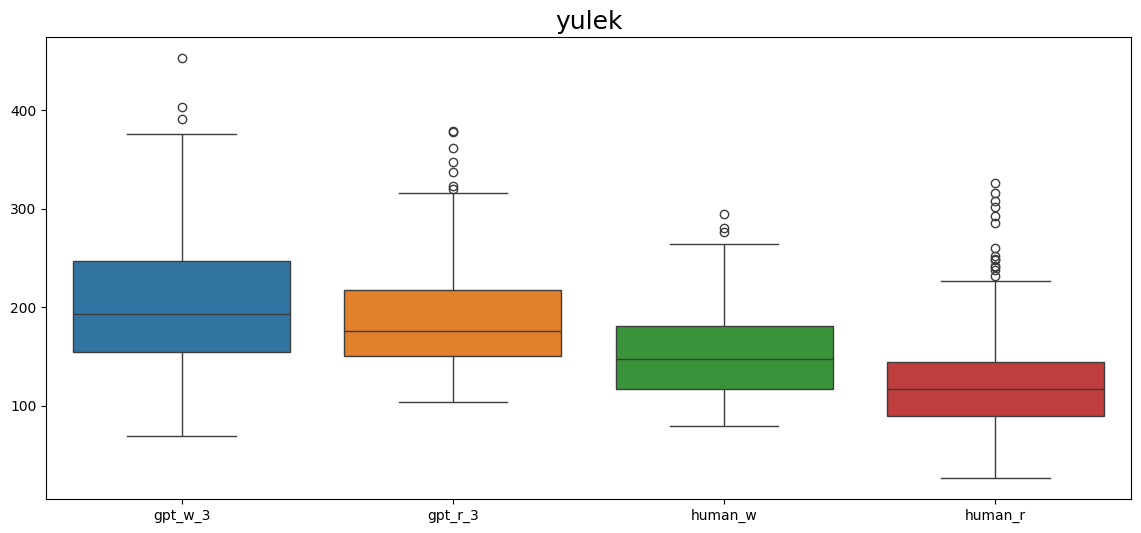

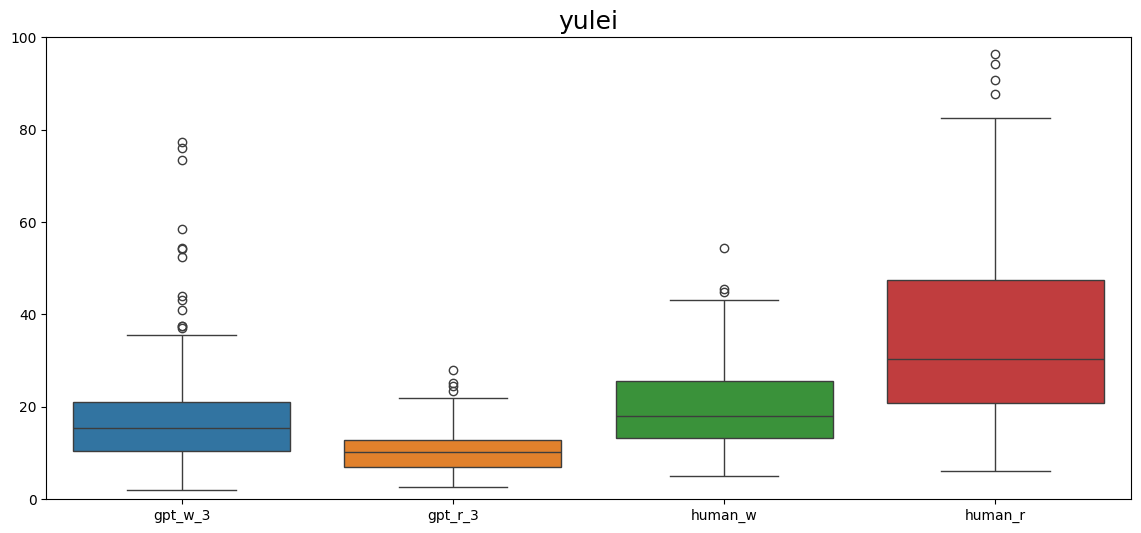

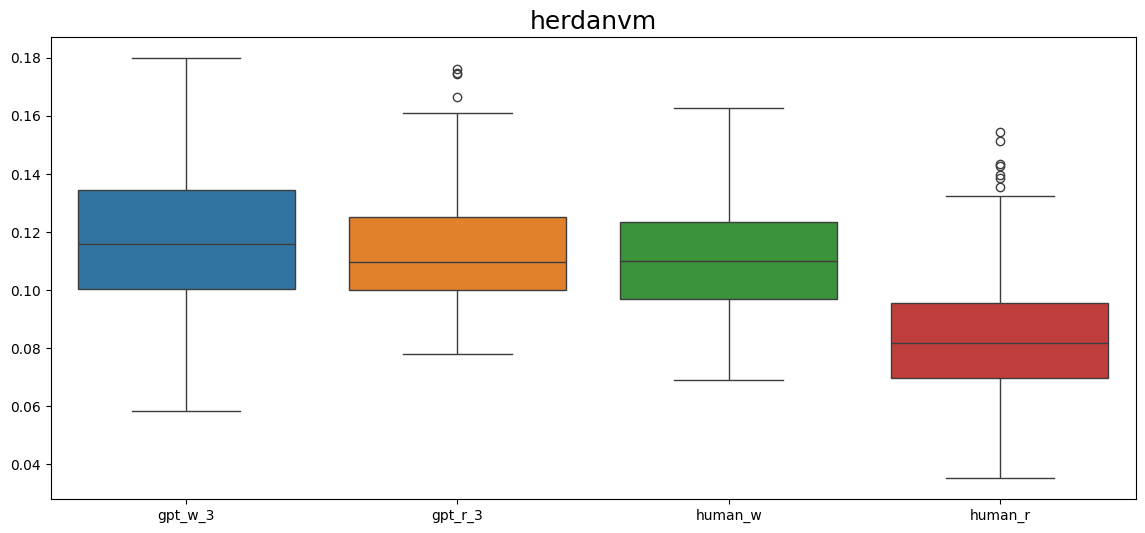

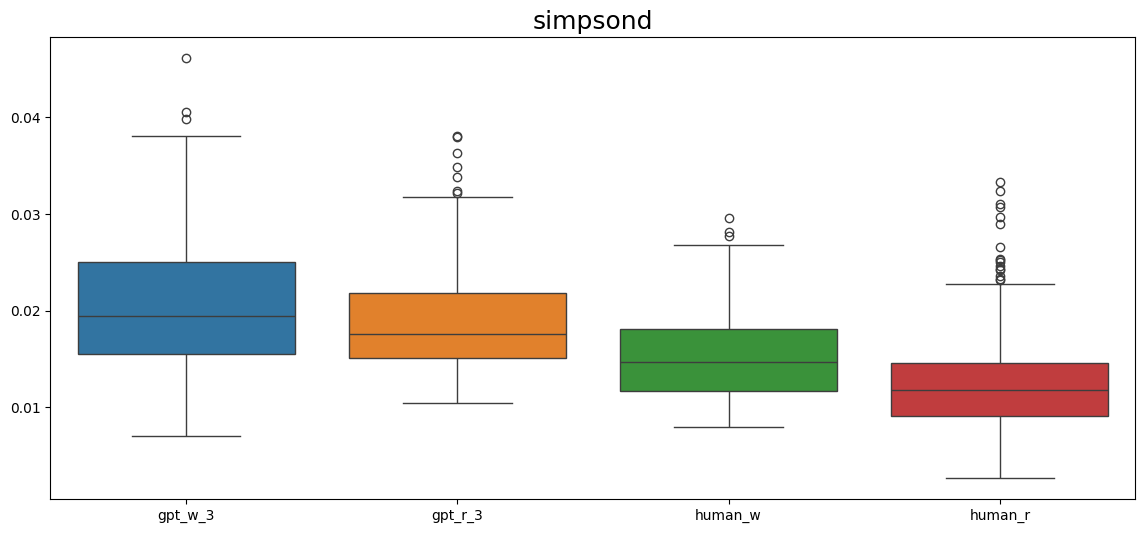

In [18]:
for lexrich_name in lexrich_functions.keys():
    fig, ax = plt.subplots(figsize=(14, 6))
    lex_rich = {}

    for train_key in text_sets.keys():
        lex_rich[train_key] = []
        for text in text_sets[train_key]:
            try:
                lex_rich[train_key].append(lexrich_functions[lexrich_name](text))
            except Exception as e:
                print(e)
                lex_rich[train_key].append(0)

    box = sns.boxplot(data=list(lex_rich.values()))
    plt.xticks(range(len(lex_rich)), list(lex_rich.keys()))
    if lexrich_ylims[lexrich_name]:
        plt.ylim(lexrich_ylims[lexrich_name])
    plt.title(lexrich_name, fontsize=18)

    plt.show()

## Loading Language Model and calculating Intrinsic Dimension from embeddings

In [14]:
### Insert here path to model files in your system
model_path = 'roberta-base'
tokenizer_path = model_path

### Loading the model
tokenizer = RobertaTokenizer.from_pretrained(tokenizer_path)
model = RobertaModel.from_pretrained(model_path)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
"""
Our method (PHD) is stochastic, here are some magic constants for it. They are chosen specifically for text data. If you plan to use this code for something different, consider testing other values.

MIN_SUBSAMPLE       --- the size of the minimal subsample to be drawn in procedure. Lesser values yields less statisitcally stable predictions.
INTERMEDIATE_POINTS --- number of sumsamples to be drawn. The more this number is, the more stable dimension estimation for single text is; however,  the computational time is higher, too. 7 is, empirically, the best trade-off.
"""
MIN_SUBSAMPLE = 40
INTERMEDIATE_POINTS = 7

In [16]:
'''
Auxillary function. Clear text from linebreaks and odd whitespaces, because they seem to interfer with LM quite a lot.
Replace with a more sophisticated cleaner, if needed.
'''

def preprocess_text(text):
    return text.replace('\n', ' ').replace('  ', ' ')

In [21]:
'''
Get PHD for one text
Parameters:
        text  --- text
        solver --- PHD computator

Returns:
    real number or NumPy.nan  --- Intrinsic dimension value of the text in the input data
                                                    estimated by Persistence Homology Dimension method.'''
def get_phd_single(text, solver):
    inputs = tokenizer(preprocess_text(text), truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outp = model(**inputs)

    # We omit the first and last tokens (<CLS> and <SEP> because they do not directly correspond to any part of the)
    mx_points = inputs['input_ids'].shape[1] - 2


    mn_points = MIN_SUBSAMPLE
    step = ( mx_points - mn_points ) // INTERMEDIATE_POINTS

    return solver.fit_transform(outp[0][0].numpy()[1:-1],  min_points=mn_points, max_points=mx_points - step, \
                                point_jump=step)

phds = {}
for key in text_sets.keys():
    phds[key] = []
    PHD_solver = PHD(metric='euclidean', n_points=3)
    for text in tqdm(text_sets[key]):
        try:
            phds[key].append(get_phd_single(text, PHD_solver))
        except Exception as e:
            print(e)
            phds[key].append(0)

  5%|▌         | 13/250 [00:07<02:07,  1.86it/s]

range() arg 3 must not be zero


100%|██████████| 250/250 [03:05<00:00,  1.35it/s]


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


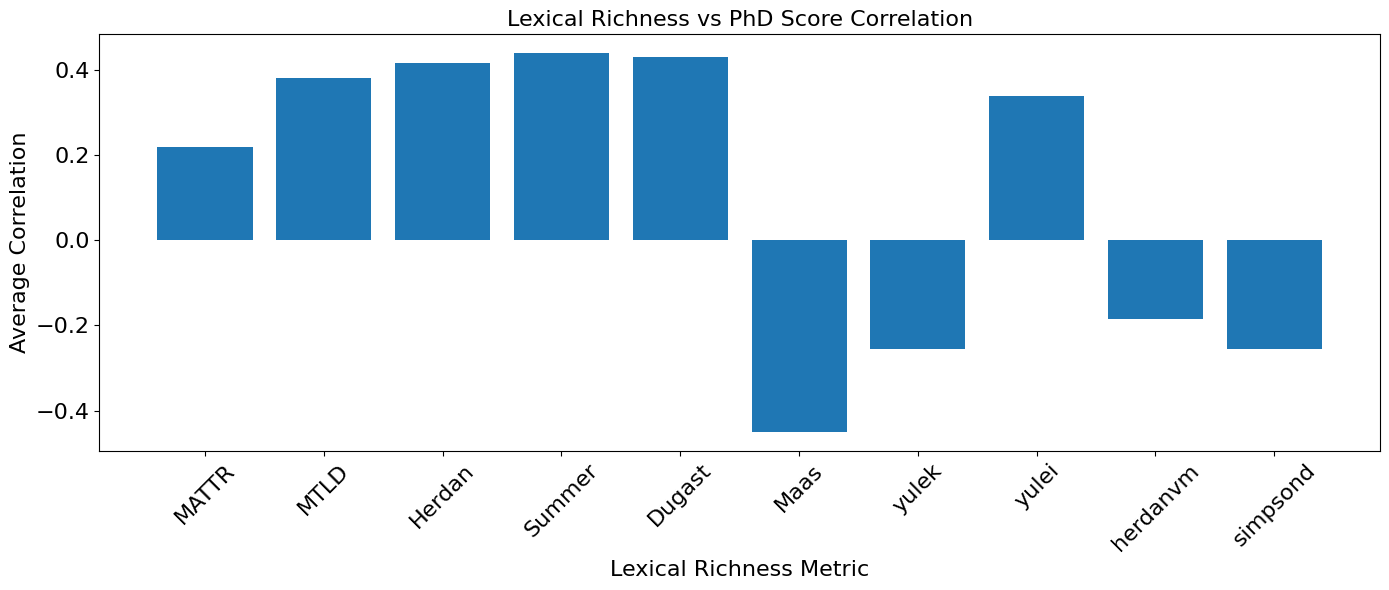

In [29]:
fig, ax = plt.subplots(figsize=(14, 6))

correlations = {}

for lexrich_name in tqdm(lexrich_functions.keys()):
    total_corr = 0
    count = 0

    for train_key in text_sets.keys():
        lex_rich_scores = []
        phd_scores = []

        for i, text in enumerate(text_sets[train_key]):
            try:
                lex_rich_scores.append(lexrich_functions[lexrich_name](text))
            except Exception as e:
                print(f"Error computing {lexrich_name} for text {i}: {e}")
                lex_rich_scores.append(0)

            phd_scores.append(phds[train_key][i])

        if len(lex_rich_scores) > 1 and len(phd_scores) > 1:
            corr_matrix = np.corrcoef(lex_rich_scores, phd_scores)
            corr_coef = corr_matrix[0, 1]
            total_corr += corr_coef
            count += 1

    correlations[lexrich_name] = total_corr / count if count > 0 else 0

# Plotting
ax.bar(correlations.keys(), correlations.values())
ax.set_ylabel("Average Correlation", fontsize=16)
ax.set_title("Lexical Richness vs PhD Score Correlation", fontsize=16)
ax.set_xlabel("Lexical Richness Metric", fontsize=16)
ax.tick_params(axis='both', labelsize=16)  # X and Y axis tick labels

plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()